In [50]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import os

In [51]:
Train_dir = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'
emotions_loc = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'

In [52]:
images = []
labels = []
i=0
for emotions in os.listdir(Train_dir):
    emotion_path = os.path.join(emotions_loc,emotions)
    for filename in os.listdir(emotion_path):
        if filename.endswith('.png'):
            image_path = os.path.join(emotion_path, filename)
            image = Image.open(image_path)
            desired_size = (224, 224)
            image = image.resize(desired_size)
            image = np.array(image)
            image = image / 255.0
            images.append(image)
            label = np.zeros(7)
            label[i] = 1
            labels.append(label)
    i+=1       

The shape of the images list is = (981, 224, 224)
The size of the images list is = 49222656
[1. 0. 0. 0. 0. 0. 0.]


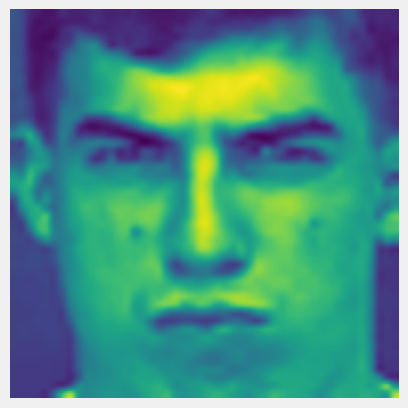

In [53]:
print("The shape of the images list is = "+str(np.shape(images)))
print("The size of the images list is = "+str(np.size(images)))

print(labels[i])
i = 98 
plt.imshow(images[i])
plt.axis('off')  # Hide axis labels and ticks
plt.show()


## Reshape the images and label matrix as necessary

In [54]:

images = np.transpose(images, (1, 2, 0))
images = images.reshape(224*224,981)
labels = np.array(labels)
labels = np.transpose(labels,(1,0))

# Shuffle the dataset
num_samples = images.shape[1]
indices = np.arange(num_samples)
np.random.shuffle(indices)
images = images[:,indices]
labels = labels[:,indices]



[1. 0. 0. 0. 0. 0. 0.]


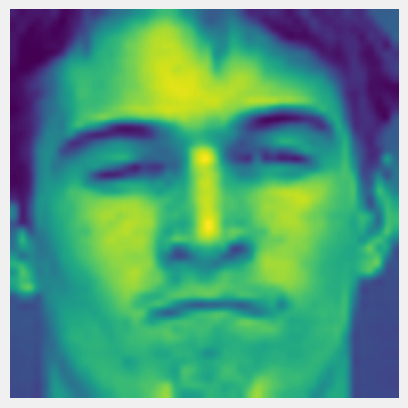

In [55]:
print(labels[:,i])
i = 1  # Change this to the index of the image you want to plot

# Select the column corresponding to the ith image
selected_image = images[:, i]

# Reshape the selected image back to its original shape (224x224)
original_shape_image = selected_image.reshape(224, 224)

plt.imshow(original_shape_image)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

## Normalizer

In [56]:
def Normalise(parameter):

    mean = np.mean(parameter)
    std = np.std(parameter)
    parameter = (parameter-mean)/(std)
    
    return parameter

def MinMax(parameter):
    
    min = np.min(parameter)
    max = np.max(parameter)
    deviation = max - min
    parameter = (parameter-min)/(deviation)
    
    return parameter

In [57]:
images = Normalise(images)
#images = MinMax(images)

images_Df=pd.DataFrame(images)
labels_Df=pd.DataFrame(labels)
images_Df

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
0,-1.083537,-1.533135,-0.443199,-1.424142,0.524120,-0.838301,-1.642129,-0.197963,-1.655753,1.695801,...,0.088145,-1.001791,-1.764747,-1.519511,-0.538568,-1.669377,-0.620314,-1.056288,-1.451390,-0.211588
1,-1.083537,-1.533135,-0.443199,-1.437766,0.469623,-0.838301,-1.655753,-0.197963,-1.655753,1.695801,...,0.074521,-1.001791,-1.764747,-1.519511,-0.538568,-1.655753,-0.620314,-1.069912,-1.451390,-0.211588
2,-1.083537,-1.546760,-0.456823,-1.451390,0.347005,-0.838301,-1.655753,-0.197963,-1.655753,1.695801,...,0.074521,-1.029040,-1.764747,-1.519511,-0.538568,-1.642129,-0.620314,-1.083537,-1.451390,-0.211588
3,-1.069912,-1.587632,-0.497696,-1.492263,0.142642,-0.838301,-1.669377,-0.197963,-1.655753,1.695801,...,0.074521,-1.056288,-1.751123,-1.505887,-0.538568,-1.601256,-0.620314,-1.124409,-1.451390,-0.211588
4,-1.056288,-1.614881,-0.565817,-1.533135,-0.143467,-0.851925,-1.710250,-0.197963,-1.655753,1.682177,...,0.060897,-1.097161,-1.751123,-1.492263,-0.538568,-1.533135,-0.620314,-1.165282,-1.437766,-0.197963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,-1.083537,-1.192530,-0.347830,0.387877,-0.129842,-0.715683,-0.783804,-0.933670,0.932846,0.142642,...,-0.783804,-1.519511,-0.811053,-1.315148,-0.947295,0.932846,-0.974543,-0.756556,-1.328772,-1.165282
50172,-1.083537,-1.192530,-0.334205,0.387877,-0.116218,-0.715683,-0.770180,-0.920046,0.646737,0.142642,...,-0.729307,-1.519511,-0.797428,-1.328772,-0.947295,0.660362,-0.933670,-0.756556,-1.342397,-1.110785
50173,-1.083537,-1.192530,-0.334205,0.387877,-0.102594,-0.715683,-0.756556,-0.892798,0.469623,0.156266,...,-0.688435,-1.505887,-0.797428,-1.328772,-0.947295,0.455998,-0.892798,-0.756556,-1.342397,-1.056288
50174,-1.083537,-1.192530,-0.334205,0.387877,-0.102594,-0.715683,-0.756556,-0.879174,0.360629,0.156266,...,-0.674811,-1.505887,-0.797428,-1.328772,-0.947295,0.360629,-0.879174,-0.756556,-1.342397,-1.042664


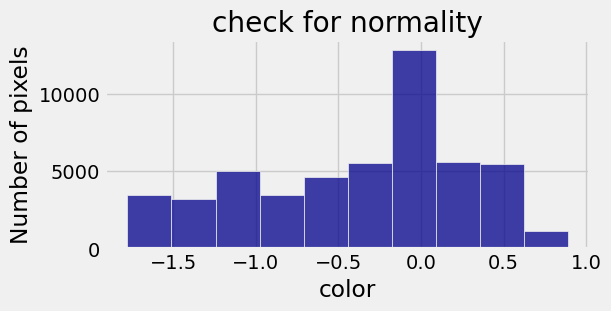

In [58]:

import matplotlib.style as style
style.use('fivethirtyeight')

fig = plt.figure(constrained_layout=True, figsize=(6,3))
sns.histplot(images_Df.loc[:,1], kde=False, color='darkblue', bins=10)
plt.xlabel('color')  # Add a label to the x-axis.
plt.ylabel('Number of pixels')  # Add a label to the y-axis.
plt.title('check for normality')  # Add a title to the plot.

plt.show()


In [59]:
images_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50176 entries, 0 to 50175
Columns: 981 entries, 0 to 980
dtypes: float64(981)
memory usage: 375.5 MB


In [60]:
images_Df.describe()

,0,1,2,3,4,5,6,7,8,9,...,971,972,973,974,975,976,977,978,979,980
count,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,...,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000,50176.000000
mean,-0.636717,-0.375066,-0.024896,0.087172,0.104672,0.385895,0.233761,0.501080,-0.459829,-0.444259,...,0.101163,-0.347900,-1.197294,-0.624593,-0.063572,0.375648,-0.226862,-0.016456,-0.674353,0.398451
std,0.673867,0.655978,0.747043,0.851329,0.868590,0.956800,1.103281,1.160554,0.833438,0.789403,...,0.924516,0.627150,0.415439,0.620963,1.007829,0.884272,0.696651,1.071573,0.621908,0.982530
min,-1.778371,-1.778371,-1.778371,-1.723874,-1.751123,-1.778371,-1.778371,-1.778371,-1.778371,-1.778371,...,-1.778371,-1.642129,-1.778371,-1.778371,-1.778371,-1.683002,-1.778371,-1.778371,-1.778371,-1.737498
25%,-1.274276,-0.906422,-0.579441,-0.511320,-0.511320,-0.470447,-0.783804,-0.633938,-1.083537,-1.138033,...,-0.729307,-0.865549,-1.533135,-1.178906,-0.920046,-0.252460,-0.756556,-0.879174,-1.287900,-0.402326
50%,-0.552193,-0.184339,-0.116218,0.156266,0.251635,0.469623,0.333381,0.823852,-0.633938,-0.497696,...,0.169890,-0.266084,-1.219779,-0.415951,-0.075345,0.415126,-0.157091,0.183514,-0.456823,0.483247
75%,-0.048097,0.088145,0.483247,0.701234,0.701234,1.259827,1.287075,1.695801,0.169890,0.183514,...,0.837476,0.169890,-0.933670,-0.102594,0.769355,1.096336,0.319756,0.946470,-0.157091,1.327948
max,0.851100,0.891973,1.695801,1.695801,1.695801,1.695801,1.695801,1.695801,1.695801,1.695801,...,1.695801,0.973718,0.987342,0.660362,1.695801,1.695801,1.436941,1.573183,0.251635,1.695801


## Divide into train, Dev and test sets

In [89]:
def split(train_percent,test_percent,images,labels):
    
    total_examples = images.shape[1]
    train_size = int(train_percent * total_examples/100)
    test_size = int(test_percent * total_examples/100)
    
    images_train = images[:,:train_size]
    images_test =  images[:,train_size:(train_size+test_size)]
    images_dev =  images[:,(train_size+test_size):]
    
    labels_train = labels[:,:train_size]
    labels_test =  labels[:,train_size:(train_size+test_size)]
    labels_dev =  labels[:,(train_size+test_size):]
    
    return (images_train,images_dev,images_test,labels_train,labels_dev,labels_test)

In [90]:
images_train,images_dev,images_test,labels_train,labels_dev,labels_test = split(80,10,images,labels)
print(images_train.shape[1])

784


## Initialise W and b for every node of each layer

In [91]:
def initialize_parameters(layers): 
    parameters = {}
    L = len(layers)
    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layers[l],layers[l-1])
        
        parameters['b' + str(l)] = np.zeros((layers[l],1))
  
    return parameters

## The Activation Fuctions

In [92]:
def sigmoid(Z):
    a = 1/(1+np.exp(-Z))
    return a

def relu(Z):
    a = np.maximum(0,Z)
    return a

def soft_max(Z):
    exp = np.exp(Z-np.max(Z,axis=0))
    a = exp/(np.sum(exp,axis=0,keepdims=True))
    return a

## Propagate forward

In [93]:
def forward_propagation(images,parameters):
    
    cache = {}
    L= int(len(parameters)/2)
    
    cache['Z'+str(1)] = (np.dot(parameters['W'+str(1)],images))+parameters['b'+str(1)]
    cache['A'+str(1)] = relu(cache['Z'+str(1)])
    cache['A'+str(1)] = Normalise(cache['A'+str(1)])
    
    for l in range(2,L):
        cache['Z'+str(l)] = (np.dot(parameters['W'+str(l)],cache['A'+str(l-1)]))+parameters['b'+str(l)]
        cache['A'+str(l)] = relu(cache['Z'+str(l)])
        cache['A'+str(l)] = Normalise(cache['A'+str(l)])
        
    cache['Z'+str(L)] = (np.dot(parameters['W'+str(L)],cache['A'+str(L-1)]))+parameters['b'+str(L)]
    cache['A'+str(L)] = soft_max(cache['Z'+str(L)])
    
    cache['A0'] = images
    A4 = cache['A'+str(L)]

    return A4,cache


## Loss Function

In [94]:
def compute_loss(A4,labels,epsilon):
    
    m = labels.shape[1]
    cost = np.sum(-(np.sum(labels*np.log(A4+epsilon),axis=0,keepdims=False)))/m
    #cost = -np.sum(np.sum(np.multiply(labels, np.log(A4)) + np.multiply((1 - labels), np.log(1 - A4)),axis=1),axis=0)/m
    
    return cost

In [95]:
def backward_propagation(images, labels, cache, parameters,epsilon):
    
    grads={}
    m=images.shape[1]
    L = int(len(cache)/2)
    
    grads['dZ'+str(L)] =  (cache['A'+str(L)]-labels)
    grads['dW'+str(L)] = np.dot(grads['dZ'+str(L)],cache['A'+str(L-1)].T)/m
    grads['db'+str(L)] = np.sum(grads['dZ'+str(L)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True 
    grads['dA'+str(L-1)] = np.dot(parameters['W'+str(L)].T,grads['dZ'+str(L)])
    
    for l in range(L-1,0,-1):
        grads['dZ'+str(l)] = np.where(cache['Z'+str(l)]>0,1,0)*grads['dA'+str(l)]
        grads['dA'+str(l-1)] = np.dot(parameters['W'+str(l)].T,grads['dZ'+str(l)])
        grads['dW'+str(l)] = np.dot(grads['dZ'+str(l)],cache['A'+str(l-1)].T)/m
        grads['db'+str(l)] = np.sum(grads['dZ'+str(l)],axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
    
    return grads

## Update Parameters

In [96]:
def update_parameters(parameters, grads, learning_rate):
    
    L = int(len(parameters)/2)
    for l in range(L):
        
        parameters['W'+str(l+1)]= (parameters['W'+str(l+1)])-(learning_rate*grads['dW'+str(l+1)])

        parameters['b'+str(l+1)]= (parameters['b'+str(l+1)])-(learning_rate*grads['db'+str(l+1)])
        
    return parameters

In [97]:
def calculate_accuracy(true_labels, A4):
    
    # Ensure that the input arrays have the same shape
    assert true_labels.shape == A4.shape, "Input shapes do not match"
 
    # Calculate the number of correct predictions
    mask1 = (np.abs(true_labels-A4)<=0.25)
    mask2 = (np.all(mask1,axis=0))
    ''''
    tl_Df = pd.DataFrame(true_labels)
    print(tl_Df)
    A4_Df = pd.DataFrame(A4)
    print(A4_Df)
    '''
    # Count the total number of times 1 appears using the mask
    num_correct = np.sum(mask2)
    
    # Calculate the total number of samples
    total_samples = true_labels.shape[1]

    # Calculate accuracy
    accuracy = (num_correct*100) / total_samples
    
    return accuracy

## Combine all the functions to create a working model

In [101]:
def predictor(images, labels, learning_rate, num_iterations=5000, print_cost = True, epsilon = 1e-15):
    grads = {}
    costs = []
    layers = [images.shape[0],10,10,10,labels.shape[0]]
    # Initialse w and b
    parameters=initialize_parameters(layers)
    
    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        A4, cache = forward_propagation(images, parameters)
        
        # Loss
        cost = compute_loss(A4, labels, epsilon)

        # Backward propagation.
        grads = backward_propagation(images, labels, cache, parameters,epsilon)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            accuracy = calculate_accuracy(labels, A4)
            print("Accuracy:", accuracy, "%")
        # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return(parameters)
    

Cost after iteration 0: 3.6521533479856605
Accuracy: 4.719387755102041 %
Cost after iteration 1000: 0.22564414750481884
Accuracy: 77.55102040816327 %
Cost after iteration 2000: 0.12640935570308984
Accuracy: 89.54081632653062 %
Cost after iteration 3000: 0.09131549083103242
Accuracy: 95.79081632653062 %
Cost after iteration 4000: 0.0735463376899646
Accuracy: 97.83163265306122 %


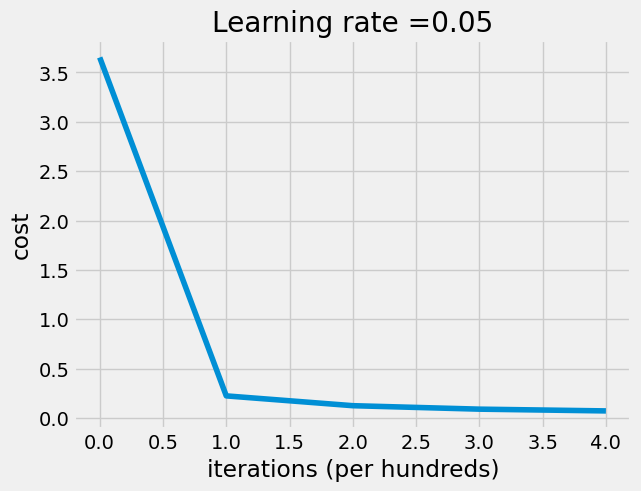

In [102]:
parameters=predictor(images_train, labels_train, learning_rate = 0.05)




## Testing


In [103]:
def dev_tester(images, labels, parameters,epsilon=1e-15):
    
    # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX.
    A4, cache = forward_propagation(images, parameters)

    cost = compute_loss(A4,labels,epsilon)
    print("Cost: ", cost)
    
    accuracy = calculate_accuracy(labels, A4)
    print("Accuracy: ", accuracy, "%")
    

In [104]:
dev_tester(images_dev,labels_dev,parameters)

Cost:  0.12106206013423093
Accuracy:  92.92929292929293 %


In [126]:
def conclusion(A4,selected_label):
    
    mask1 = (np.abs(selected_label-A4)<=0.25)
    print(mask1)
    mask2 = (np.all(mask1,axis=0))
    flag = False
    
    
    if(mask2==True):
        for i in range(selected_label.shape[0]):
            if(selected_label[i]>=A4[i]):
                flag = True
                break
        if(flag):
            if(i==0):
                print("The expression is Angry")
            elif(i==1):
                print("The expression is Contempt")
            elif(i==2):
                print("The expression is Disgust")
            elif(i==3):
                print("The expression is Fear")
            elif(i==4):
                print("The expression is Happy")
            elif(i==5):
                print("The expression is Sadness")
            elif(i==6):
                print("The expression is Surprise")
    else:
        print("Sorry but the output was wrong")

In [127]:
def tester(images,labels,parameters,i):
    
    # Select the column corresponding to the ith image
    selected_image = images[:, i]
    selected_label = labels[:, i]
    
    # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX.
    A4, cache = forward_propagation(images, parameters)
    
    print(selected_label)
    
    # Reshape the selected image back to its original shape (224x224)
    original_shape_image = selected_image.reshape(224, 224)
    plt.imshow(original_shape_image)
    plt.axis('off')  # Hide axis labels and ticks
    plt.show()
    
    conclusion(A4[:,i],selected_label)

[0. 0. 0. 0. 0. 0. 1.]


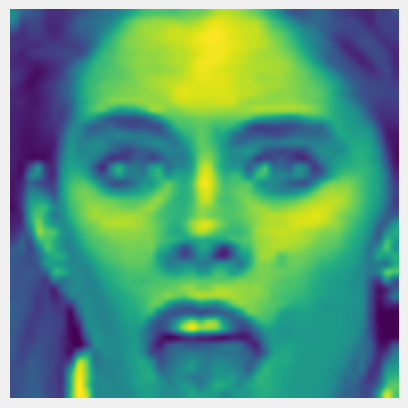

[ True  True  True  True  True  True  True]
The expression is Surprise


In [134]:
i=13
tester(images_test,labels_test,parameters,i)